In [1]:
import sys, os, pickle
import pandas as pd
import numpy as np

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from create_datasets.create_table_datasets import adni_data
from ml_models.machine_learning_models import create_class_ADNI, baseline_model
from ml_models.utils import boxplot_comparison_models, statistics, barplot_comparison_models

**1. Create table datasets**

Create table datasets (with and without APOE) for the targets and genes of interest to use as input for non-GNN models.

In [2]:
# Input: type of variant, best network from previous analysis, missense data, diagnosis/metadata
table_dataset = adni_data('missense',
                          'data/other_networks/AD_SNAP_PPI_brain.edgelist',
                          'data/ADNI/AD_PPI_missense.csv',
                          'data/ADNI/ADNIMERGE_metadata.csv')
table_dataset.to_csv(f'data/table_datasets/AD_PPI_missense_ADNI_labeled.csv')

**2. Baseline models - Logistic Regression only with APOE**

In [21]:
targets = ['PET', 'PETandDX']

for target in targets:
    
    result_df = pd.DataFrame(columns = ['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])

    data = pd.read_csv('data/table_datasets/AD_PPI_missense_ADNI_labeled.csv', index_col = 0)
    data_wclass = create_class_ADNI(data, target)

    x = data_wclass.drop(columns=['y'])
    x = x['APOE']

    y = data_wclass['y']
    x.index = x.index.str.upper()

    for i in range(10):

        i += 1

        f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
        split = pickle.load(f)
        f.close()

        tr_idx = split['train']
        te_idx = split['valid']

        x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
        y_train, y_test = y[tr_idx], y[te_idx]

        x_train = np.array(x_train).reshape(-1, 1)
        x_test = np.array(x_test).reshape(-1, 1)

        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        logreg = LogisticRegression()
        logreg.fit(x_train_scaled, y_train)

        y_prob = logreg.predict_proba(x_test_scaled)

        y_pred = logreg.predict(x_test_scaled)
        acc = metrics.accuracy_score(y_test, y_pred)
        pre = metrics.precision_score(y_test, y_pred)
        rec = metrics.recall_score(y_test, y_pred)
        f1  = metrics.f1_score(y_test, y_pred)
        auc = metrics.roc_auc_score(y_test, y_prob[:, 1])

        result_df.loc[len(result_df)] = [i, target, 'AD PPT-Ohmnet', 'Logistic Regression - Only APOE', acc, pre, rec, f1, auc]

    result_df.to_csv(f'results/2022_03_baseline_models_{target}.csv', index=False)

**3. Other non-GNN models: Logistic Regression, SVM Linear, SVM RBF, Random Forest**

In [61]:
for target in ['PET', 'PETandDX']:
    
    print(target)
    
    # Obtain table dataset, label it with the corresponding target and delete genes that do not have mutations (all zeroes)
    data = pd.read_csv('data/table_datasets/AD_PPI_missense_ADNI_labeled.csv', index_col = 0)
    data_wclass = create_class_ADNI(data, target)
    data_wclass = data_wclass.loc[:, (data_wclass != 0).any(axis=0)]
    
    x = data_wclass.drop(columns=['y'])
    y = data_wclass['y']
    x.index = x.index.str.upper()
    
    results = [] # list of lists that stores performance metrics
    
    for i in range(10):

        i += 1
        
        print('Fold', i)
        print('-------------------------------------------------')

        f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
        split = pickle.load(f)
        f.close()

        tr_idx = split['train']
        te_idx = split['valid']

        x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
        y_train, y_test = y[tr_idx], y[te_idx]

    #     x_train = np.array(x_train).reshape(-1, 1)
    #     print(x_train.shape)
    #     x_test = np.array(x_test).reshape(-1, 1)

        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        # Logistic Regression
        logreg = LogisticRegression()
        logreg.fit(x_train_scaled, y_train)
        y_prob_logreg = logreg.predict_proba(x_test_scaled)
        y_pred_logreg = logreg.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet', 'Logistic Regression',
                        metrics.accuracy_score(y_test, y_pred_logreg),
                        metrics.precision_score(y_test, y_pred_logreg),
                        metrics.recall_score(y_test, y_pred_logreg),
                        metrics.f1_score(y_test, y_pred_logreg),
                        metrics.roc_auc_score(y_test, y_prob_logreg[:, 1])])

        # SVM Linear
        svm_lin = SVC(probability=True)
        param_grid_svm_lin = [{'C': [0.01, 0.1, 1, 10, 100, 1000]}]
        grid_search_svm_lin = GridSearchCV(svm_lin, param_grid_svm_lin, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_svm_lin.fit(x_train_scaled, y_train)
        print(grid_search_svm_lin.best_estimator_)
        y_prob_svm_lin = grid_search_svm_lin.predict_proba(x_test_scaled)
        y_pred_svm_lin = grid_search_svm_lin.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet', 'SVM Linear',
                        metrics.accuracy_score(y_test, y_pred_svm_lin),
                        metrics.precision_score(y_test, y_pred_svm_lin),
                        metrics.recall_score(y_test, y_pred_svm_lin),
                        metrics.f1_score(y_test, y_pred_svm_lin),
                        metrics.roc_auc_score(y_test, y_prob_svm_lin[:, 1])])

        # SVM RBF
        svm_rbf = SVC(probability=True, kernel='rbf')
        param_grid_svm_rbf = [{'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}]
        grid_search_svm_rbf = GridSearchCV(svm_rbf, param_grid_svm_rbf, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_svm_rbf.fit(x_train_scaled, y_train)
        print(grid_search_svm_rbf.best_estimator_)
        y_prob_svm_rbf = grid_search_svm_rbf.predict_proba(x_test_scaled)
        y_pred_svm_rbf = grid_search_svm_rbf.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet', 'SVM RBF',
                        metrics.accuracy_score(y_test, y_pred_svm_rbf),
                        metrics.precision_score(y_test, y_pred_svm_rbf),
                        metrics.recall_score(y_test, y_pred_svm_rbf),
                        metrics.f1_score(y_test, y_pred_svm_rbf),
                        metrics.roc_auc_score(y_test, y_prob_svm_rbf[:, 1])])

        # Random Forest
        rf_clf = RandomForestClassifier()
        param_grid = [{'n_estimators': [50, 500, 5000]}]
        grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_rf.fit(x_train, y_train)
        print(grid_search_rf.best_estimator_)
        y_prob_rf = grid_search_rf.predict_proba(x_test)
        y_pred_rf = grid_search_rf.predict(x_test)
        results.append([i, target, 'AD PPT-Ohmnet', 'Random Forest',
                        metrics.accuracy_score(y_test, y_pred_rf),
                        metrics.precision_score(y_test, y_pred_rf),
                        metrics.recall_score(y_test, y_pred_rf),
                        metrics.f1_score(y_test, y_pred_rf),
                        metrics.roc_auc_score(y_test, y_prob_rf[:, 1])])

        print()
        
    results_df = pd.DataFrame(results, columns=['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])
    results_df.to_csv(f'results/2022_03_nonGNN_models_{target}.csv', index=False)


PET
Fold 1
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.01, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.01, gamma=1, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=5000)

Fold 2
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=10, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.01, gamma=1, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=5000)

Fold 3
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=1000, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=10, gamma=0.1, probability=True)
Fitting 10 folds for each of 3 candidate

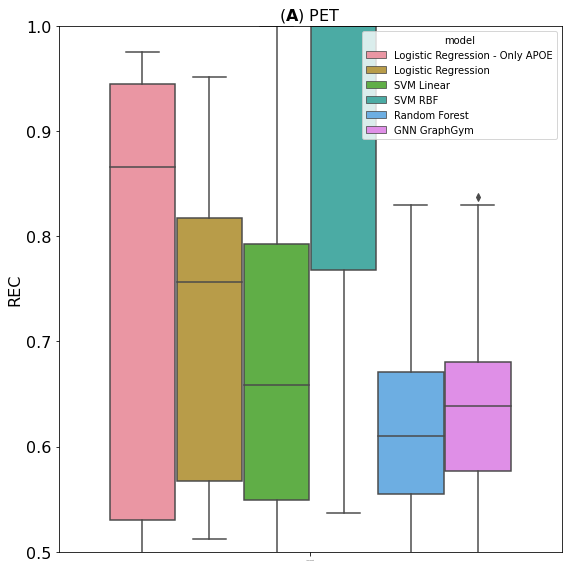

In [7]:
pet_noGNN = pd.read_csv('results/2022_03_nonGNN_models_PET.csv', index_col='fold')
pet_GNN   = pd.read_csv('results/2022_03_networks_PET.csv', index_col='fold')
pet_bas   = pd.read_csv('results/2022_03_baseline_models_PET.csv',  index_col='fold')
pet_all   = pd.concat([pet_noGNN, pet_GNN, pet_bas])
pet_all = pet_all.loc[pet_all['dataset'] == 'AD PPT-Ohmnet']
boxplot_comparison_models('PET', pet_all, 'rec', r"($\bf{A}$) PET")

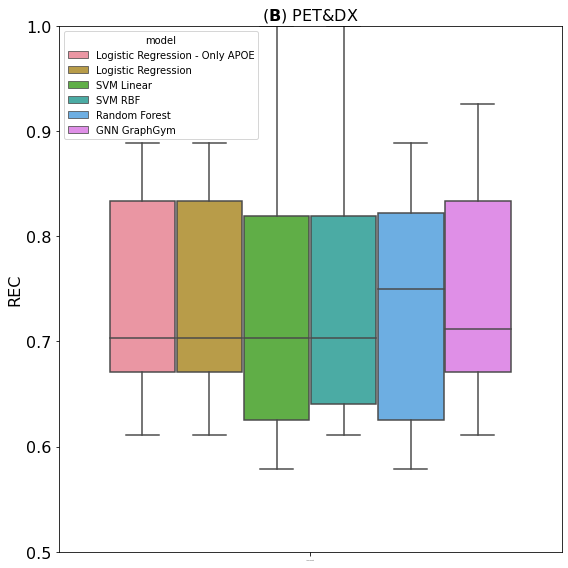

In [6]:
petdx_noGNN = pd.read_csv('results/2022_03_nonGNN_models_PETandDX.csv', index_col='fold')
petdx_GNN   = pd.read_csv('results/2022_03_networks_PETandDX.csv', index_col='fold')
petdx_bas   = pd.read_csv('results/2022_03_baseline_models_PETandDX.csv',  index_col='fold')
petdx_all   = pd.concat([petdx_noGNN, petdx_GNN, petdx_bas])
petdx_all   = petdx_all.loc[petdx_all['dataset'] == 'AD PPT-Ohmnet']
boxplot_comparison_models('PET&DX', petdx_all, 'rec', r"($\bf{B}$) PET&DX")